In [312]:
#import libaries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import pm4py
# Log Conversion (pandas to log and vice versa)
from pm4py.objects.conversion.log import factory as log_conv
from pm4py.util import constants
from pm4py.util.business_hours import BusinessHours
from pm4py.objects.conversion.log import converter as log_converter
from pm4py.objects.conversion.log import converter as log_conversion
from pm4py.objects.log.util import interval_lifecycle
from datetime import datetime
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler

The goal of this master thesis is to illustrate how process mining techniques can be combined with machine learning techniques to add explainability to the predictions to the previously black box prediction models.

# Step 1: Load Data from event log and preprocess it

In [2]:
def read_file(file_name):
    """
    loads event log data frame from file_name which is realtive path
    """
    df = pd.read_csv(file_name)
    return df

In [3]:
def preprocess_df(df):
    """Preprocessing function that parses the timestamps and resource information.
    :df: DataFrame that should be processed
    :returns: Preprocessed DataFrame
    """
    # Convert start timestamp
    df['Start Timestamp'] = pd.to_datetime(df['Start Timestamp'])
    # Convert end timestamp
    df['Complete Timestamp'] = pd.to_datetime(df['Complete Timestamp'])
    return df

In [4]:
#fill missing values ( taken from https://github.com/PyRicky/LSTM_Generic_explainable/blob/master/load_dataset.py )
def fill_missing_end_dates(df, start_date_position, end_date_position):
    df[df.columns[end_date_position]] = df.apply(lambda row: row[start_date_position]
                  if row[end_date_position] == 0 else row[end_date_position], axis=1)
    return df

In [9]:
#here not a problem beacuse no missing values to be filled
df[df.isna().any(axis=1)]

Empty DataFrame
Columns: [Case ID, Activity, Complete Timestamp, AMOUNT_REQ, Start Timestamp, Resource]
Index: []

In [5]:
def sort_df(df):
    df.sort_values(["Case ID","Start Timestamp"], axis=0, ascending=True, inplace=True, kind='quicksort', na_position='last')
    return df

In [6]:
#load and preprocess event log
file_name = "data/BPI2012.csv"
df = read_file(file_name)
df = preprocess_df(df)

In [7]:
#sort df
df = sort_df(df)

In [8]:
df.head()

Case ID                Activity  Complete Timestamp  AMOUNT_REQ  \
0   173688             A_SUBMITTED 2011-10-01 00:38:00       20000   
1   173688       A_PARTLYSUBMITTED 2011-10-01 00:38:00       20000   
2   173688           A_PREACCEPTED 2011-10-01 00:39:00       20000   
3   173688           A_PREACCEPTED 2011-10-01 00:39:00       20000   
4   173688  W_Completeren aanvraag 2011-10-01 11:45:00       20000   

      Start Timestamp  Resource  
0 2011-10-01 00:38:00       112  
1 2011-10-01 00:38:00       112  
2 2011-10-01 00:38:00       112  
3 2011-10-01 00:38:00       112  
4 2011-10-01 00:38:00       112

In [338]:
#convert to log
# Mapping between dataset columns and PM4Py keys
# Many functions will require you to pass this as additional parameters
param_keys={constants.PARAMETER_CONSTANT_CASEID_KEY: 'Case ID',
    constants.PARAMETER_CONSTANT_RESOURCE_KEY: 'Resource', 
    constants.PARAMETER_CONSTANT_ACTIVITY_KEY: 'Activity',
    constants.PARAMETER_CONSTANT_START_TIMESTAMP_KEY: 'Start Timestamp',
    constants.PARAMETER_CONSTANT_TIMESTAMP_KEY: 'Complete Timestamp'}
log = log_conv.apply(df, parameters=param_keys)

apply is deprecated as of 1.3.0 and will be removed in 2.0.0. Use algorithm entrypoint instead


# Step 2: Functions for adding converting event log into feature vector

In [10]:
#Step 1: enrich event log with temporal information about cycle time and partial lead time and convert to df
param_keys={constants.PARAMETER_CONSTANT_CASEID_KEY: 'Case ID',
    constants.PARAMETER_CONSTANT_RESOURCE_KEY: 'Resource', 
    constants.PARAMETER_CONSTANT_ACTIVITY_KEY: 'Activity',
    constants.PARAMETER_CONSTANT_START_TIMESTAMP_KEY: 'Start Timestamp',
    constants.PARAMETER_CONSTANT_TIMESTAMP_KEY: 'Complete Timestamp',
    "business_hours": True,
    "weekends":[6,7]}
enriched_log = interval_lifecycle.assign_lead_cycle_time(log, parameters=param_keys)
enriched_df = log_converter.apply(enriched_log, variant=log_converter.Variants.TO_DATA_FRAME)
enriched_df = enriched_df.drop(enriched_df.columns[-1], axis=1)
enriched_df.head()

@@approx_bh_overall_wasted_time  @@approx_bh_partial_cycle_time  \
0                                0                               0   
1                                0                               0   
2                                0                               0   
3                                0                               0   
4                                0                               0   

   @@approx_bh_partial_lead_time  @@approx_bh_this_wasted_time  \
0                              0                             0   
1                              0                             0   
2                              0                             0   
3                              0                             0   
4                              0                             0   

   @approx_bh_ratio_cycle_lead_time  AMOUNT_REQ                Activity  \
0                               1.0       20000             A_SUBMITTED   
1                               1.0       20000       A_PARTLYSUBMITTED   
2                               1.0       20000           A_PREACCEPTED   
3                               1.0       20000           A_PREACCEPTED   
4                               1.0       20000  W_Completeren aanvraag   

   Case ID  Complete Timestamp  Resource     Start Timestamp  
0   173688 2011-10-01 00:38:00       112 2011-10-01 00:38:00  
1   173688 2011-10-01 00:38:00       112 2011-10-01 00:38:00  
2   173688 2011-10-01 00:39:00       112 2011-10-01 00:38:00  
3   173688 2011-10-01 00:39:00       112 2011-10-01 00:38:00  
4   173688 2011-10-01 11:45:00       112 2011-10-01 00:38:00

In [11]:
def calculate_workload(df,engaged_resources,case_start,event_end):
    """
     returns mean of total number of cases being worked on by an active resource involved for the caseID passed
    """
    res = []
    for resource in engaged_resources:
        res_cases = len(df[(df["Resource"]==resource)&(df["Start Timestamp"]>=case_start)&(df["Start Timestamp"]<=event_end)]["Case ID"].unique())
        res.append(res_cases)
    avg=sum(res)/len(res)
    return avg        

In [12]:
def calculate_business_hours(st,et,weekends):
    #st = datetime.fromtimestamp(100000000)
    #et = datetime.fromtimestamp(200000000)
    bh_object = BusinessHours(st, et,weekends)
    print(bh_object.gethours())
    worked_time = bh_object.getseconds()
    print(worked_time)

In [116]:
def add_contextual_info(df, case_info, case_start, case_end, event_start, event_end, last_event_time,case):
    #add information that pertains to the number of cases at a timepoint    
    #number of cases that arrived after the start time of the case and before the end
    #case_start = list(case_info[(case_info["Case ID"]==case)]["Start Timestamp"].values)[0]
    #case_end = list(case_info[(case_info["Case ID"]==case)]["Complete Timestamp"].values)[0]
    X=dict()
    
    #ADD CASE RELATED INFORMATION
    #number of cases that arrived since case start
    X["cases_arrived"]= len(case_info[(case_info["Start Timestamp"]>=case_start) & (case_info["Start Timestamp"]<=event_end)]["Case ID"])
    #number of cases that finished since case start
    X["cases_finished"]= len(case_info[(case_info["Complete Timestamp"]>=case_start)&(case_info["Complete Timestamp"]<=event_end)]["Case ID"])
    #number of cases that are not finished before case starts i.e. backlog of applications
    X["cases_backlog"]= len(case_info[(case_info["Start Timestamp"]<=case_start)&(case_info["Complete Timestamp"]>=case_start)])                                      
    
    #ADD RESOURCE AND WORKLOAD RELATED INFORMATION
    X["number_of_resources_for_case"] = len(list(df[(df["Case ID"]==case)]["Resource"].unique()))
    engaged_resources= df[(df["Start Timestamp"]>=case_start)&(df["Start Timestamp"]<=event_end)]["Resource"].unique()
    total_resources = len(df["Resource"].unique())
    X["free_resources"] = total_resources-len(engaged_resources)
    X["avg_work_load"] = calculate_workload(df,engaged_resources,case_start,event_end)
    #X["Resource_role"] = cluster_resource()
    
    #environment information
    #X["time_from_case_start"] = (event_start - case_start).total_seconds()
    #X["time_from_last_event"] = (event_start - last_event_time).total_seconds()
    X["Weekday"] = pd.to_datetime(case_start).weekday()
    
    #add target column
    X["remaining_time"] = (pd.to_datetime(case_end) - pd.to_datetime(event_end)).total_seconds()
    
    #update time when last event happened
    last_event_time = event_end
    
    return last_event_time, X                           

In [117]:
def create_sliding_windows(df,prefix_length):
    dataframe = df
    for i in range(1,prefix_length):
        cols = {x: str(x)+"_"+str(i) for x in df.columns}
        d2= df.shift(i).rename(columns=cols)
        dataframe = pd.concat([dataframe,d2], axis=1)
    dataframe = dataframe.dropna()
    return dataframe

In [118]:
#convert to sequences with ids
from mlxtend.preprocessing import TransactionEncoder
te = TransactionEncoder()
def create_transaction_encoding(values,keys):
    #activities = df["Activity"].unique()
    id_dict = dict()
    for key in keys:
        id_dict[key] = 0
    unique,counts = np.unique(values,return_counts=True)
    for key,val in zip(unique,counts):
        id_dict[key]=val
    return id_dict

In [119]:
def create_boolean_encoding(values,keys):
    id_dict = dict()
    for key in keys:
        id_dict[key] = False
    unique,counts = np.unique(values,return_counts=True)
    for key,val in zip(unique,counts):
        id_dict[key]= True if val>0 else False
    return id_dict

In [177]:
def add_tracewise_features(enriched_df,case, prefix_length,case_info, mode):
    """
    returns a sliding window dataframe for this case    
    """
    case_start = list(case_info[(case_info["Case ID"]==case)]["Start Timestamp"].values)[0]
    case_end = list(case_info[(case_info["Case ID"]==case)]["Complete Timestamp"].values)[0]
    case_df = enriched_df[(enriched_df["Case ID"]==case)].reset_index(drop=True)
    traces = []
    context_info = []
    last_event_time = list(case_df["Complete Timestamp"])[0]
    for i,row in case_df.iterrows():
        event_end = pd.to_datetime(row["Complete Timestamp"])
        event_start = pd.to_datetime(row["Start Timestamp"])
        last_event_time,X = add_contextual_info(enriched_df, case_info, case_start, case_end, event_start, event_end, last_event_time,case)
        context_info.append(X)
    #join enriched_df with contextual_info
    context_df = pd.DataFrame.from_records(context_info)
    dataframe = pd.concat([case_df,context_df],axis=1)
    
    activities = []
    resources = []
    
   
    if mode=="aggregate":
        activities = create_transaction_encoding(list(case_df["Activity"][:prefix_length]),enriched_df["Activity"].unique())
        resources = create_transaction_encoding(list(case_df["Resource"][:prefix_length]),enriched_df["Resource"].unique())
        #take last row values from dataframe
        dataframe = dataframe.drop(columns=["Activity","Resource"],axis=1).loc[prefix_length-1,:]
    else:
         #generate sequences for gradient boosted tree i.e. sliding windows
        dataframe = create_sliding_windows(dataframe,prefix_length)

    
    return activities,resources,dataframe

In [178]:
def prepare_feature_set(case,prefix_length, mode):
    #aggregate start and complete times of each case ID which is needed for the feature generation
    activities,resources,dataframe =add_tracewise_features(enriched_df,case, prefix_length,case_info,mode)
    return activities,resources,dataframe

In [210]:
data = pd.DataFrame()
cases = list(enriched_df["Case ID"].unique())
temp = enriched_df[["Case ID", "Start Timestamp", "Complete Timestamp"]]
case_info = temp.groupby("Case ID").agg({"Start Timestamp": min, "Complete Timestamp":max}).reset_index() 
activity_df = []
resource_df = []
for case in cases[:200]:
    activities, resources, X = prepare_feature_set(case,3,mode="sequential")
    activity_df.append(activities) 
    resource_df.append(resources)
    data = data.append(X,ignore_index=True)
#activity_df = pd.DataFrame.from_records(activity_df)
#resource_df = pd.DataFrame.from_records(resource_df)
#data = data.join(activity_df).join(resource_df)
#data.head()

In [211]:
data.head()

@@approx_bh_overall_wasted_time  @@approx_bh_partial_cycle_time  \
0                                0                               0   
1                                0                               0   
2                                0                               0   
3                                0                               0   
4                                0                               0   

   @@approx_bh_partial_lead_time  @@approx_bh_this_wasted_time  \
0                              0                             0   
1                              0                             0   
2                              0                             0   
3                              0                             0   
4                              0                             0   

   @approx_bh_ratio_cycle_lead_time  AMOUNT_REQ                Activity  \
0                               1.0       20000           A_PREACCEPTED   
1                               1.0       20000           A_PREACCEPTED   
2                               1.0       20000  W_Completeren aanvraag   
3                               1.0       20000              A_ACCEPTED   
4                               1.0       20000              O_SELECTED   

   Case ID  Complete Timestamp  Resource        ...        Resource_2  \
0   173688 2011-10-01 00:39:00       112        ...             112.0   
1   173688 2011-10-01 00:39:00       112        ...             112.0   
2   173688 2011-10-01 11:45:00       112        ...             112.0   
3   173688 2011-10-01 11:42:00     10862        ...             112.0   
4   173688 2011-10-01 11:45:00     10862        ...             112.0   

    Start Timestamp_2  Weekday_2  avg_work_load_2  cases_arrived_2  \
0 2011-10-01 00:38:00        5.0         1.000000              1.0   
1 2011-10-01 00:38:00        5.0         1.000000              1.0   
2 2011-10-01 00:38:00        5.0         1.000000              1.0   
3 2011-10-01 00:38:00        5.0         1.000000              1.0   
4 2011-10-01 00:38:00        5.0         1.896552             12.0   

   cases_backlog_2  cases_finished_2  free_resources_2  \
0              1.0               0.0              63.0   
1              1.0               0.0              63.0   
2              1.0               0.0              63.0   
3              1.0               0.0              63.0   
4              1.0               2.0              39.0   

   number_of_resources_for_case_2  remaining_time_2  
0                             5.0         1072740.0  
1                             5.0         1072740.0  
2                             5.0         1072680.0  
3                             5.0         1072680.0  
4                             5.0         1032720.0  

[5 rows x 57 columns]

# Step 3:Derive Advanced Features

# Step 3.1. use a decisision tree to learn decision points

In [343]:
from pm4py.objects.log.util import get_log_representation
data, feature_names = get_log_representation.get_representation(log,str_ev_attr=["Activity", "Resource"],
                                                                str_tr_attr=[], num_ev_attr=[], num_tr_attr=[])

data, feature_names = get_log_representation.get_default_representation(log, parameters=param_keys)
from pm4py.objects.log.util import get_class_representation
target, classes = get_class_representation.get_class_representation_by_trace_duration(log,2*24*5*3600)

In [344]:
from sklearn import tree
clf = tree.DecisionTreeClassifier()
clf.fit(data, target)

from pm4py.visualization.decisiontree import visualizer as dectree_visualizer
gviz = dectree_visualizer.apply(clf, feature_names, classes)

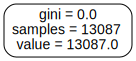

In [345]:
gviz

#exploring pm4py
from pm4py.util import xes_constants as xes
from pm4py.statistics.traces.pandas import case_statistics
from pm4py.statistics.variants.log import get as variants_filter
resource_key = exec_utils.get_param_value(Parameters.RESOURCE_KEY, param_keys, xes.DEFAULT_RESOURCE_KEY)

parameters_variants = {case_statistics.Parameters.ACTIVITY_KEY: resource_key,
                       case_statistics.Parameters.ATTRIBUTE_KEY: resource_key}
variants_occ = {x: len(y) for x, y in variants_filter.get_variants(log1, parameters=parameters_variants).items()}
variants_resources = list(variants_occ.keys())
variants_occ

In [245]:
#kmeans clustering --helper function
from sklearn.cluster import KMeans
def cluster_traces_kmeans(X,n):
    clustering = KMeans(n_clusters=n, random_state=0).fit(X)
    return clustering.labels_

In [298]:
#dbscan clustering --helper function
from sklearn.cluster import DBSCAN
def cluster_traces_DBSCAN(X):
    clustering = DBSCAN(eps=0.5, min_samples = 2).fit(X)
    return clustering.labels_

In [300]:
from scipy.cluster.hierarchy import dendrogram, linkage, cut_tree
def cluster_traces_linkage(X,n):
    Z = linkage(X, 'ward')
    labels = cut_tree(Z, n_clusters=n)
    labels = [item for sublist in labels for item in sublist]
    return labels

In [255]:
#calculate case arrival/dispersion rate for trace taken from pm4py mostly
def calculate_case_arrival_rate(resources):
    timest_key = "Start Timestamp"
    arrival_rates = []
    for resource in resources:        
        first = df[df["Resource"]==resource].groupby("Case ID").first()
        first_df = first.sort_values(timest_key)
        first_df_shift = first_df.shift(-1)
        first_df_shift.columns = [str(col) + '_2' for col in first_df_shift.columns]

        df_successive_rows = pd.concat([first_df, first_df_shift], axis=1)
        df_successive_rows['interlapsed_time'] = (
                df_successive_rows[timest_key + '_2'] - df_successive_rows[timest_key]).astype('timedelta64[s]')

        df_successive_rows = df_successive_rows.dropna(subset=['interlapsed_time'])
        arrival_rates.append(df_successive_rows['interlapsed_time'].mean())

    case_arrival_df = pd.DataFrame({"case_arrival":arrival_rates})
    return case_arrival_df    

In [258]:
#calculate case arrival/dispersion rate for trace taken from pm4py mostly
def calculate_case_dispersal_rate(resources):
    timest_key = "Complete Timestamp"
    dispersal_rates = []
    for resource in resources:        
        first = df[df["Resource"]==resource].groupby("Case ID").last()
        first_df = first.sort_values(timest_key)
        first_df_shift = first_df.shift(-1)
        first_df_shift.columns = [str(col) + '_2' for col in first_df_shift.columns]

        df_successive_rows = pd.concat([first_df, first_df_shift], axis=1)
        df_successive_rows['interlapsed_time'] = (
                df_successive_rows[timest_key + '_2'] - df_successive_rows[timest_key]).astype('timedelta64[s]')

        df_successive_rows = df_successive_rows.dropna(subset=['interlapsed_time'])
        dispersal_rates.append(df_successive_rows['interlapsed_time'].mean())

    case_dispersal_df = pd.DataFrame({"case_dispersal":dispersal_rates})
    return case_dispersal_df 

In [247]:
#function to create traces of activities performed by resources
def create_activity_frequency_vector(resource, activityList):
    column_names=list(df["Activity"].unique())
    #column_names=["Resource"]+column_names
    X=pd.DataFrame(columns=column_names)
    activities,counts = np.unique(np.array(activityList),return_counts=True)
    freq_dict = dict()
    for a,val in zip(activities,counts):
        freq_dict[a]=val
    for col in column_names[:]:
        X.loc[0,col] = freq_dict.get(col,0)
    return X

In [248]:
# create feature vector for resources based on activities performed
def cluster_traces_resources():
    resources = df["Resource"].unique()
    res_activity_vector = pd.DataFrame()
    for res in resources:
        activityList=list(df[df["Resource"]==res]["Activity"])
        X=create_activity_frequency_vector(res,activityList)
        res_activity_vector=res_activity_vector.append(X,ignore_index=True)
    return res_activity_vector

In [273]:
# to differential between behavior of a resource
#sequential: case arrival rate should be high and case dispersal rate should be high too
#batch: case arrival rate is low and case dispersal should be low too..
# high case arrival rate and low case dispersal or vice-versa?

In [277]:
def normalize_data(df):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(df.iloc[:, :].values)
    columns = [x for x in df.columns]
    df = pd.DataFrame(scaled, columns=columns)
    return df

In [278]:
resources = df["Resource"].unique()
case_arrival_df = calculate_case_arrival_rate(resources)
case_dispersal_df = calculate_case_dispersal_rate(resources)
#use fillna for resources that only worked on one case
case_arrival_dispersal_df = pd.concat([case_arrival_df,case_dispersal_df], axis = 1).fillna(1)
case_arrival_dispersal_df = normalize_data(case_arrival_dispersal_df)
case_arrival_dispersal_df.head()

case_arrival  case_dispersal
0      0.000561        0.000894
1      0.034198        0.050025
2      0.004407        0.006921
3      0.005895        0.008908
4      0.011320        0.017946

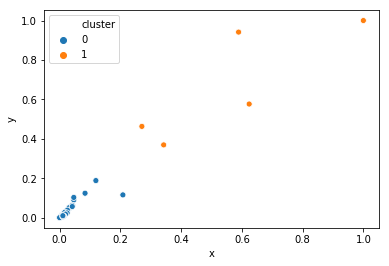

In [279]:
#cluster them into categories Sequential or Batch
X=np.array(case_arrival_dispersal_df)
n=2
labels = cluster_traces_kmeans(X,n)
clustering_df=pd.DataFrame({"x":case_arrival_dispersal_df["case_arrival"], "y":case_arrival_dispersal_df["case_dispersal"],"cluster":labels})
import seaborn as sns
sns.scatterplot(data=clustering_df,x="x", y="y",hue="cluster")

In [282]:
# define labels based on figure and add them to resource dataframe
behavior_labels = list(map(lambda x: "Batch" if x==0 else "Sequential",labels))
dataframe1 = cluster_traces_resources()
dataframe2 = pd.DataFrame({"behavior":behavior_labels})
resource_behavior_df = pd.concat([dataframe1,dataframe2], axis=1)
resource_behavior_df.head()

A_SUBMITTED  A_PARTLYSUBMITTED  A_PREACCEPTED  W_Completeren aanvraag  \
0        13087              17893           9704                    1045   
1            0                  0             84                      16   
2            0                  0            154                     762   
3            0                  0              0                      16   
4            0                  0             86                      48   

   A_ACCEPTED  O_SELECTED  A_FINALIZED  O_CREATED  O_SENT  \
0           0           0            0          0       0   
1          51          80           50         80     160   
2         166         222          167        222     444   
3           0          10            0         10      20   
4          28          48           27         48      96   

   W_Nabellen offertes    ...     O_ACCEPTED  A_ACTIVATED  O_CANCELLED  \
0                    9    ...              0            3          560   
1                  100    ...              0            0           47   
2                 1067    ...              0            0          105   
3                  878    ...              0            0           24   
4                   46    ...            359          359           22   

   A_DECLINED  A_CANCELLED  W_Afhandelen leads  O_DECLINED  \
0        3429         1004                 742           0   
1          35           26                   0           1   
2         155           82                 190          11   
3           2           21                   0           2   
4         119            1                  85          90   

   W_Nabellen incomplete dossiers  W_Beoordelen fraude  behavior  
0                               0                    0     Batch  
1                               0                    0     Batch  
2                             801                    0     Batch  
3                            1127                    0     Batch  
4                             200                    0     Batch  

[5 rows x 24 columns]

In [319]:
#apply tsne clustering to visualise high dimensional data to cluster resources based on activities and behavior
from sklearn.manifold import TSNE
tsne = TSNE( learning_rate = 50)
X = resource_behavior_df.iloc[:,:-1]
tsne_features = tsne.fit_transform(X)

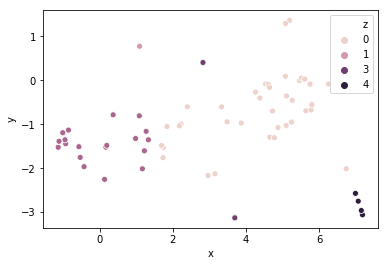

In [320]:
# Visualise clusters to chose an appropriate k
labels = cluster_traces_kmeans(X,5)
clustering_df = pd.DataFrame({'x':tsne_features[:,0],'y':tsne_features[:,1],'z':np.array(labels),'behavior':resource_behavior_df.iloc[:,-1]})
clustering_df["cluster"] = clustering_df["z"].apply(lambda x: "Cluster_"+str(x))
import seaborn as sns
sns.scatterplot(data=clustering_df,x="x", y="y", hue="z")
#plt.show()

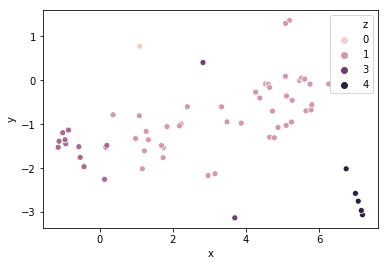

In [321]:
# Visualise clusters to chose an appropriate n for linkage method
labels = cluster_traces_linkage(X,5)
clustering_df = pd.DataFrame({'x':tsne_features[:,0],'y':tsne_features[:,1],'z':np.array(labels),'behavior':resource_behavior_df.iloc[:,-1]})
clustering_df["cluster"] = clustering_df["z"].apply(lambda x: "Cluster_"+str(x))
import seaborn as sns
sns.scatterplot(data=clustering_df,x="x", y="y", hue="z")

#conclusion: k=4 or k=5

In [313]:
# cross check results with sna analysis
#discover roles based on work together
from pm4py.algo.enhancement.sna import algorithm as sna
path_save_base = os.path.abspath('./')
df1=df
df1["Resource"]=df1["Resource"].apply(str)
log1 = log_conv.apply(df1, parameters=param_keys)
log1 = log_conversion.apply(log1, parameters=param_keys)
wt_values = sna.apply(log1, parameters=param_keys,variant=sna.Variants.JOINTACTIVITIES_LOG)
from pm4py.visualization.sna import factory as sna_vis_factory
gviz_hw_py = sna_vis_factory.apply(wt_values, variant="pyvis")
sna_vis_factory.save(gviz_hw_py, os.path.join(path_save_base, 'sna_joint activities.html'), variant="pyvis")
distance_matrix=wt_values[0]

apply is deprecated as of 1.3.0 and will be removed in 2.0.0. Use algorithm entrypoint instead
apply is deprecated as of 1.3.0 and will be removed in 2.0.0. Use visualizer module instead.
save is deprecated as of 1.3.0 and will be removed in 2.0.0. Use visualizer module instead.


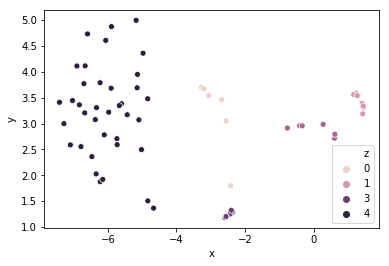

In [317]:
#reapeat clustering with this metric
# Visualise clusters to chose an appropriate n for linkage method
#apply tsne clustering to visualise high dimensional data to cluster resources based on activities and behavior
from sklearn.manifold import TSNE
tsne = TSNE( learning_rate = 50)
X = distance_matrix
tsne_features = tsne.fit_transform(X)
labels = cluster_traces_linkage(X,5)
clustering_df = pd.DataFrame({'x':tsne_features[:,0],'y':tsne_features[:,1],'z':np.array(labels),'behavior':resource_behavior_df.iloc[:,-1]})
clustering_df["cluster"] = clustering_df["z"].apply(lambda x: "Cluster_"+str(x))
import seaborn as sns
sns.scatterplot(data=clustering_df,x="x", y="y", hue="z")

# Step 4: Implement DT

# Failed XGBOOST IMP

In [29]:
#split in test and train
X_train = data[data.columns[:-1]][:-10]
Y_train = data["remaining time"][:-10]
X_test = data[data.columns[:-1]][-10:]
Y_test = data["remaining time"][-10:]

In [30]:
#encode categorical vaiables
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
categorical_features = ["Activities","resource_last_ev"]
for feature in categorical_features:
    categorical_feature = X_train[feature]  
    categorical_feature_encoded = le.fit(categorical_feature).transform(categorical_feature)
    X_train[feature] = categorical_feature_encoded
    categorical_feature = X_test[feature]  
    categorical_feature_encoded = le.fit(categorical_feature).transform(categorical_feature)
    X_test[feature] = categorical_feature_encoded    

In [31]:
X_test

Activities  amt_last_ev  resource_last_ev  cases_arrived  cases_finished  \
0           2        20000                 0            947             534   
1           0        20000                 0            947             534   
2           1        20000                 0            947             534   
3           2         5000                 0            717             370   
4           0         5000                 0            717             370   
5           1         5000                 0            717             370   

   cases_backlog  number_of_resources_for_case  free_resources  avg_work_load  
0              1                             5              14      75.518519  
1              1                             5              14      75.518519  
2              1                             5              14      75.518519  
3              2                             5              16      58.673077  
4              2                             5              16      58.673077  
5              2                             5              16      58.673077

In [18]:
from xgboost import XGBRegressor
model = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
model.fit(X_train, Y_train)
#preds = model.predict(X_test)
#preds = [round(pred) for pred in preds]

[09:45:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:59: Label set is empty.
[09:45:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:59: Label set is empty.
[09:45:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:59: Label set is empty.
[09:45:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:59: Label set is empty.
[09:45:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:59: Label set is empty.
[09:45:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:59: Label set is empty.
[09:45:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:59: Label set is empty.
[09:45:00] WARNING: C:/Users/Administrato

[09:45:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:59: Label set is empty.
[09:45:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:59: Label set is empty.
[09:45:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:59: Label set is empty.
[09:45:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:59: Label set is empty.
[09:45:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:59: Label set is empty.
[09:45:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:59: Label set is empty.
[09:45:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:59: Label set is empty.
[09:45:00] WARNING: C:/Users/Administrato

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
       importance_type='gain', interaction_constraints='',
       learning_rate=0.300000012, max_delta_step=0, max_depth=6,
       min_child_weight=1, missing=nan, monotone_constraints='()',
       n_estimators=1000, n_jobs=0, num_parallel_tree=1,
       objective='reg:squarederror', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
       validate_parameters=1, verbosity=None)

In [22]:
preds = model.predict(X_test)
Y_test, preds
#preds = [round(pred) for pred in preds]

(0    1072680.0
 1    1072680.0
 2    1072680.0
 3     799680.0
 4     799680.0
 5     799680.0
 Name: remaining time, dtype: float64,
 array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5], dtype=float32))

In [49]:
data.dtypes

Activity_0                       object
Activity_1                       object
Activity_2                       object
amt_last_ev                       int64
resource_last_ev                  int64
cases_arrived                     int64
cases_finished                    int64
cases_backlog                     int64
number_of_resources_for_case      int64
free_resources                    int64
avg_work_load                   float64
remaining time                  float64
dtype: object

In [52]:
# Create y
y = data["remaining time"]

# Candidate X
cols_with_missing = [col for col in data.columns 
                                 if data[col].isnull().any()]

X_candidate = data.drop(['remaining time'] + cols_with_missing, axis=1)

low_cardinality_cols = [cname for cname in X_candidate.columns if 
                                X_candidate[cname].dtype == "object"]
numeric_cols = [cname for cname in X_candidate.columns if 
                                X_candidate[cname].dtype in ['int64', 'float64']]

my_cols = low_cardinality_cols + numeric_cols

# One hot encoded
one_hot_encoded_X = pd.get_dummies(X_candidate[my_cols])
print("# of columns after one-hot encoding: {0}".format(len(one_hot_encoded_X.columns)))

# of columns after one-hot encoding: 11


# LGB Model

In [212]:
#remove all rows where remaining time is 0
drop_indices = data[data["remaining_time"+"_"+str(i)]==0.0].index
data = data.drop(drop_indices)
#split in test and train
i=2
X=data.drop(columns=["remaining_time"+"_"+str(i)],axis=1)
X_train = X[X.columns][:-10]
Y_train = data["remaining_time"+"_"+str(i)][:-10]
X_test = X[X.columns][-10:]
Y_test = data["remaining_time"+"_"+str(i)][-10:]

In [187]:
#remove all rows where remaining time is 0 if mode==aggregate
#drop_indices = data[(data["remaining_time"==0.0])].index
#print(drop_indices)
#data = data.drop(drop_indices)
#split in test and train
i=2
X=data.drop(columns=["remaining_time"],axis=1)
X_train = X[X.columns][:-10]
Y_train = data["remaining_time"][:-10]
X_test = X[X.columns][-10:]
Y_test = data["remaining_time"][-10:]

In [213]:
X_train.head()

@@approx_bh_overall_wasted_time  @@approx_bh_partial_cycle_time  \
0                                0                               0   
1                                0                               0   
2                                0                               0   
3                                0                               0   
4                                0                               0   

   @@approx_bh_partial_lead_time  @@approx_bh_this_wasted_time  \
0                              0                             0   
1                              0                             0   
2                              0                             0   
3                              0                             0   
4                              0                             0   

   @approx_bh_ratio_cycle_lead_time  AMOUNT_REQ                Activity  \
0                               1.0       20000           A_PREACCEPTED   
1                               1.0       20000           A_PREACCEPTED   
2                               1.0       20000  W_Completeren aanvraag   
3                               1.0       20000              A_ACCEPTED   
4                               1.0       20000              O_SELECTED   

   Case ID  Complete Timestamp  Resource               ...                \
0   173688 2011-10-01 00:39:00       112               ...                 
1   173688 2011-10-01 00:39:00       112               ...                 
2   173688 2011-10-01 11:45:00       112               ...                 
3   173688 2011-10-01 11:42:00     10862               ...                 
4   173688 2011-10-01 11:45:00     10862               ...                 

  Complete Timestamp_2  Resource_2   Start Timestamp_2  Weekday_2  \
0  2011-10-01 00:38:00       112.0 2011-10-01 00:38:00        5.0   
1  2011-10-01 00:38:00       112.0 2011-10-01 00:38:00        5.0   
2  2011-10-01 00:39:00       112.0 2011-10-01 00:38:00        5.0   
3  2011-10-01 00:39:00       112.0 2011-10-01 00:38:00        5.0   
4  2011-10-01 11:45:00       112.0 2011-10-01 00:38:00        5.0   

   avg_work_load_2  cases_arrived_2  cases_backlog_2  cases_finished_2  \
0         1.000000              1.0              1.0               0.0   
1         1.000000              1.0              1.0               0.0   
2         1.000000              1.0              1.0               0.0   
3         1.000000              1.0              1.0               0.0   
4         1.896552             12.0              1.0               2.0   

   free_resources_2  number_of_resources_for_case_2  
0              63.0                             5.0  
1              63.0                             5.0  
2              63.0                             5.0  
3              63.0                             5.0  
4              39.0                             5.0  

[5 rows x 56 columns]

In [189]:
# mode =="aggregate"
date_time_columns = [cname for cname in X.columns if 
                                X[cname].dtype == "datetime64[ns]"]
#also drop CASE ID
case_id_cols = ["Case ID", "Case ID_1", "Case ID_2"]
for id_case in case_id_cols:
    date_time_columns.append(id_case)
X_test = X_test.drop(date_time_columns,axis=1)
X_train = X_train.drop(date_time_columns,axis=1)
categorical_cols = ["Weekday"]
for feature in categorical_cols:
    X_train[feature] = X_train[feature].astype('category')
    X_test[feature] = X_test[feature].astype('category')

In [214]:
#preprocess dataframe to convert certain numeric datatypes like resource to str
# drop all time stamp columns
#convert all categorical varibales to dtype category for lightgbm
date_time_columns = [cname for cname in X.columns if 
                                X[cname].dtype == "datetime64[ns]"]
case_id_cols = ["Case ID", "Case ID_1", "Case ID_2"]
for id_case in case_id_cols:
    date_time_columns.append(id_case)
X_test = X_test.drop(date_time_columns,axis=1)
X_train = X_train.drop(date_time_columns,axis=1)
cols=["Activity","Resource", "Weekday"]
#cols = ["Weekday"]
all_cols=[]
all_cols.append(cols)
prefix_length=3
for i in range(1,prefix_length):
    cols_new = list(map(lambda x:x+"_"+str(i),cols))
    all_cols.append(cols_new)
#flatten list
categorical_cols = [item for sublist in all_cols for item in sublist ]
for feature in categorical_cols:
    X_train[feature] = X_train[feature].astype('category')
    X_test[feature] = X_test[feature].astype('category')

In [215]:
X_train.head()

@@approx_bh_overall_wasted_time  @@approx_bh_partial_cycle_time  \
0                                0                               0   
1                                0                               0   
2                                0                               0   
3                                0                               0   
4                                0                               0   

   @@approx_bh_partial_lead_time  @@approx_bh_this_wasted_time  \
0                              0                             0   
1                              0                             0   
2                              0                             0   
3                              0                             0   
4                              0                             0   

   @approx_bh_ratio_cycle_lead_time  AMOUNT_REQ                Activity  \
0                               1.0       20000           A_PREACCEPTED   
1                               1.0       20000           A_PREACCEPTED   
2                               1.0       20000  W_Completeren aanvraag   
3                               1.0       20000              A_ACCEPTED   
4                               1.0       20000              O_SELECTED   

  Resource Weekday  avg_work_load               ...                \
0      112       5       1.000000               ...                 
1      112       5       1.000000               ...                 
2      112       5       1.896552               ...                 
3    10862       5       1.896552               ...                 
4    10862       5       1.896552               ...                 

   AMOUNT_REQ_2              Activity_2  Resource_2  Weekday_2  \
0       20000.0             A_SUBMITTED       112.0        5.0   
1       20000.0       A_PARTLYSUBMITTED       112.0        5.0   
2       20000.0           A_PREACCEPTED       112.0        5.0   
3       20000.0           A_PREACCEPTED       112.0        5.0   
4       20000.0  W_Completeren aanvraag       112.0        5.0   

   avg_work_load_2  cases_arrived_2  cases_backlog_2  cases_finished_2  \
0         1.000000              1.0              1.0               0.0   
1         1.000000              1.0              1.0               0.0   
2         1.000000              1.0              1.0               0.0   
3         1.000000              1.0              1.0               0.0   
4         1.896552             12.0              1.0               2.0   

   free_resources_2  number_of_resources_for_case_2  
0              63.0                             5.0  
1              63.0                             5.0  
2              63.0                             5.0  
3              63.0                             5.0  
4              39.0                             5.0  

[5 rows x 47 columns]

In [232]:
params = {

    'nthread': 10,
     'max_depth': 5,
#         'max_depth': 9,
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression_l1',
    'metric': 'mape', # this is abs(a-e)/max(1,a)
#         'num_leaves': 39,
    'num_leaves': 64,
    'learning_rate': 0.2,
   'feature_fraction': 0.9,
#         'feature_fraction': 0.8108472661400657,
#         'bagging_fraction': 0.9837558288375402,
   'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'lambda_l1': 3.097758978478437,
    'lambda_l2': 2.9482537987198496,
#       'lambda_l1': 0.06,
#       'lambda_l2': 0.1,
    'verbose': 1,
    'min_child_weight': 6.996211413900573,
    'min_split_gain': 0.037310344962162616,
    }

lgb_train = lgb.Dataset(X_train,Y_train,categorical_feature= categorical_cols)
lgb_valid = lgb.Dataset(X_test,Y_test,categorical_feature = categorical_cols)
model = lgb.train(params, lgb_train, 3000, valid_sets=[lgb_train, lgb_valid],early_stopping_rounds=100, verbose_eval=50)

Using categorical_feature in Dataset.
categorical_feature in param dict is overridden.


Training until validation scores don't improve for 100 rounds.
[50]	training's mape: 3.44244	valid_1's mape: 6.4375
[100]	training's mape: 2.80874	valid_1's mape: 8.63633
[150]	training's mape: 2.44049	valid_1's mape: 1.70136
[200]	training's mape: 2.43153	valid_1's mape: 0.809078
[250]	training's mape: 1.84538	valid_1's mape: 1.17424
[300]	training's mape: 1.3441	valid_1's mape: 0.635376
[350]	training's mape: 1.24627	valid_1's mape: 0.819827
Early stopping, best iteration is:
[280]	training's mape: 1.57339	valid_1's mape: 0.563354


In [244]:
y_pred =model.predict(X_train)
print(metrics.mean_absolute_error(np.array(Y_train), y_pred))

24276.29272424414


In [226]:
# fit a lightGBM model to the data
#start = time()
model = lgb.LGBMRegressor(loss_function= 'mean_squared_error', custom_metric=['Accuracy','AUC'],eval_metric='F1')
model.fit(X_train, Y_train, eval_set=(X_test, Y_test), feature_name='auto', categorical_feature = 'auto', verbose=50)
#model_elapse = time() - start
#print('elapse:, ', model_elapse)
print(); print(model)
# make predictions
expected_y  = Y_test
y_pred = model.predict(X_test)
expected_y, y_pred
#print(metrics.mean_absolute_error(np.array(Y_test), y_pred))

[50]	valid_0's l2: 3.99022e+09
[100]	valid_0's l2: 1.64579e+09

LGBMRegressor(custom_metric=['Accuracy', 'AUC'], eval_metric='F1',
              loss_function='mean_squared_error')


(2771    307140.0
 2772    221520.0
 2773     45180.0
 2775     47340.0
 2776     47340.0
 2777     47340.0
 2778     13800.0
 2779     13800.0
 2780     13800.0
 2781       120.0
 Name: remaining_time_2, dtype: float64,
 array([270318.05540375, 232529.77999682, 164245.51961355,  38154.67101703,
         41343.53453499,  34537.67868322,  24126.03212519,  26083.95774063,
         26385.20873725,  10321.5358384 ]))

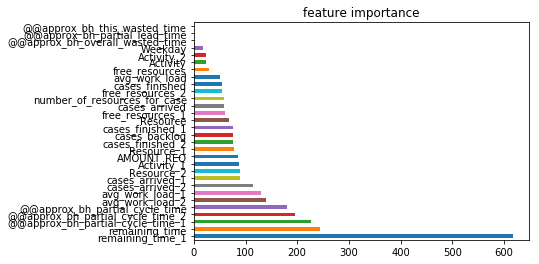

In [227]:
feat_imp = pd.Series(model.feature_importances_, index=X_train.columns)
feat_imp.nlargest(30).plot(kind='barh')
plt.title("feature importance")
plt.show()

# SHAP Values

In [235]:
import xgboost
import shap

# load JS visualization code to notebook
shap.initjs()

# train XGBoost model
# X,y = shap.datasets.boston()
# model = xgboost.train({"learning_rate": 0.01}, xgboost.DMatrix(X, label=y), 100)

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train.iloc[0,:])

In [241]:
# visualize the training set predictions
shap.force_plot(explainer.expected_value, shap_values, X_train)

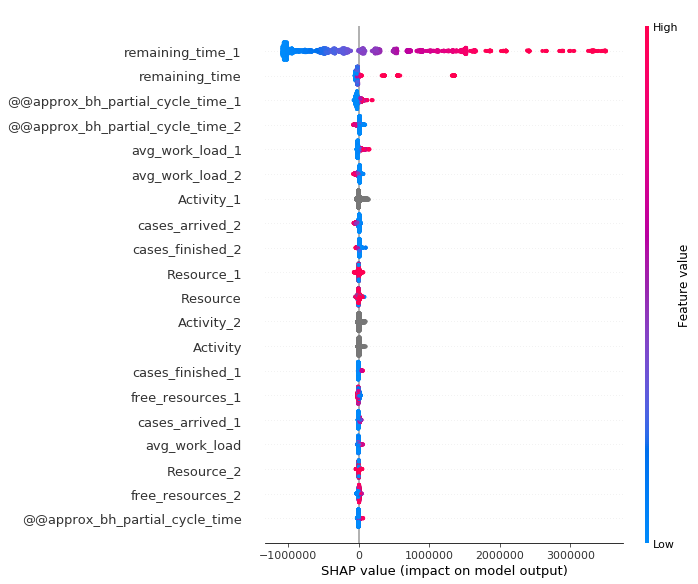

In [240]:
# summarize the effects of all the features
shap.summary_plot(shap_values, X_train)